# Windowed-Sinc-Filter und Moving Average auf einem EKG-Signal

**Eingangssignal $u(t), U(f)$**: EKG-Signal, abgetastet mit $f_a$=256 Hz, mit leichter Grundlinienschwankung und Netzbrumm bei 50 Hz

**Filter $h[k], H(f)$:** Windowed Sinc-Filter
- Fensterlänge und Grenzfrequenz sind  einstellbar. Gesamtlänge des Filters: 2M+1
- Filtertypen: Hochpass und Tiefpass mit Rechteck-Fenster und Hann-Fenster

**Ausgangssignal $y(t), y(f)$**: Gefiltertes Signal (Originalsignal grau dargestellt) 

Zum Vergleich ist auch ein Moving-Average-Filter der Länge M als einzigem Parameter auswählbar, der Grenzfrequenz-Slider wird in dem Fall ignoriert.

*Tipp: Die Graphen sind recht schmal voreingestellt, um auf kleinen Tablets sichtbar zu sein.Verwenden Sie das graue Dreieck, um sie zu vergrößern*


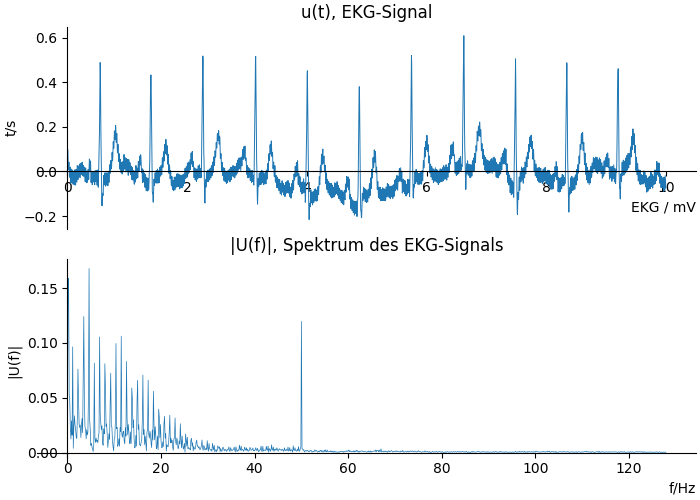

In [2]:
# (c) Benno Dömer, HS Pforzheim 2022
import platform
if platform.system() == "Emscripten": # running in JupyterLite
    %pip install -r runtime-requirements.txt

%matplotlib widget 

import numpy as np
from numpy import (pi, sqrt, sin, fft, arange, zeros, ones, sinc) 
import matplotlib.pyplot as plt
from scipy import signal
import ipywidgets as widgets # interaktive Controls wie Slider, Dropdowns etc.

def myplotstyle(ax): # Hilfsfunktion, hübscht den Plot etwas auf
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.spines['bottom'].set_position(('data',0))
    ax.yaxis.set_ticks_position('left')
    ax.spines['left'].set_position(('data',0))
    
figs, axs = plt.subplots(2,1,figsize=(7, 5), dpi=100, layout='constrained',num='Signal')
    
ecg_raw  = np.loadtxt('ecg.csv') # EKG-Rohdaten, fs = 256, Länge 20 s
fs=256
ta=1/fs

ts = 1/fs*arange(0,len(ecg_raw))
plnoise = 0.03*sin(2*pi*50*ts)
ecg_raw = ecg_raw + plnoise # 50Hz-Brumm

#Signal plotten im Zeitbereich
axs[0].cla()
axs[0].plot(ts,ecg_raw,linewidth=.7)
axs[0].set_title('u(t), EKG-Signal')
axs[0].set_xlabel('EKG / mV',loc='right')
axs[0].set_ylabel('t/s')
myplotstyle(axs[0])

#Signal plotten im Frequenzbereich
fsig=arange(0,4*fs)*1/8
Hs = np.fft.fft(ecg_raw[fs:9*fs])
Hs = abs(Hs*ta)
axs[1].cla()
axs[1].plot(fsig,Hs[0:4*fs],linewidth=.5)
axs[1].set_title('|U(f)|, Spektrum des EKG-Signals')
axs[1].set_ylabel('|U(f)|')
axs[1].set_xlabel('f/Hz',loc='right')
myplotstyle(axs[1])
plt.show()

Output()

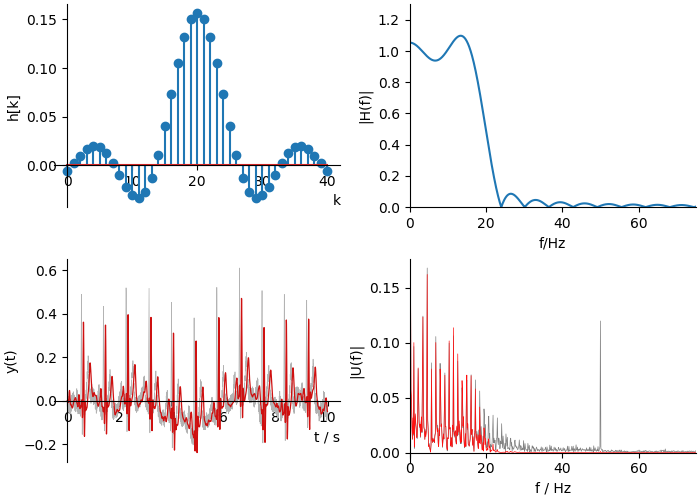

In [3]:
figf, axf = plt.subplots(2,2,figsize=(7, 5), dpi=100, layout='constrained',num='Filter')


def plotdata(ftype, m, fg, z): # filtertyp 'lp' oder 'hp', M wie in GSV, fg Grenzfrequenz in Hz
    #Impulsantwort erstellen
    k=arange(0,2*m+1)
    if ftype == 'lp':
        hk = ta*(2*fg*sinc(2*fg*ta*(k-m)))#*hann(2*M+1)
    elif ftype == 'lph':
        hk = ta*(2*fg*sinc(2*fg*ta*(k-m)))*signal.windows.hann(2*m+1)
    elif ftype == 'hp': 
        hk = -ta*(2*fg*sinc(2*fg*ta*(k-m)))#*hann(2*M+1)
        hk[int(m)]=hk[int(m)]+1.0
    elif ftype == 'hph': # hp hann
        hk = -ta*(2*fg*sinc(2*fg*ta*(k-m)))*signal.windows.hann(2*m+1)
        hk[int(m)]=hk[int(m)]+1.0
    else:
        k=arange(0,m)
        hk = 1/m*ones(m)
    # Frequenzgang erstellen
    ax=axf[0][0]
    ax.cla()
    ax.stem(k,hk)
    ax.set_xlabel('k',loc='right')
    ax.set_ylabel('h[k]')
       
    H = np.fft.fft(hk,4096)
    df=1/(4096*ta)
    f=df*arange(0,2048)
    ax=axf[0][1]
    ax.cla()
    ax.plot(f,abs(H[0:2048]))
    ax.set_xlabel('f/Hz')
    ax.set_ylabel('|H(f)|')
    ax.set_ylim(0,1.3)
    ax.set_xlim(0,75)
    
    #filtern

    ecg_fil=signal.lfilter(hk,1,ecg_raw)
    ax=axf[1][0]
    ax.cla()
    ax.plot(ts,ecg_raw,color='.7',linewidth=.5)
    ax.plot(ts,ecg_fil,color='#CF1010',linewidth=.9)
    ax.set_xlabel('t / s',loc='right')
    ax.set_ylabel('y(t)')
    if z:
        ax.set_xlim(0,3)


    Hr = np.fft.fft(ecg_fil[fs:9*fs])
    Hr = abs(Hr*ta)
    ax=axf[1][1]
    ax.cla()
    ax.plot(fsig,Hs[0:4*fs],color='#808080',linewidth=.5)
    ax.plot(fsig,Hr[0:4*fs],color='#FF1010',linewidth=.5)
    ax.set_xlabel('f / Hz')
    ax.set_ylabel('|U(f)|')
    ax.set_xlim(0,75)
    
    for i in [0,1]:
        for j in [0,1]:
            myplotstyle(axf[i][j])
    figs.canvas.draw()
    figf.canvas.draw()
    
    
# Interaktion: 
# Definition von Controls: 
typecombo = widgets.Dropdown(options=[('Tiefpass','lp'),('Hochpass','hp'),('Tiefpass, Hann','lph'),('Hochpass, Hann','hph'), ('Moving Average','ma')],value='lp',description='Filtertyp')
mslider  = widgets.IntSlider(min=1, max=100, step=1, value=20, continuous_update=True, description='$M$')
fgslider  = widgets.FloatSlider(min=0.1, max=75, step=0.1, value=20, continuous_update=True, description='$f_g$')
zoomcb  = widgets.Checkbox(value=False, description='Zoom')

# Arrangieren hier in horizontale Box:
ui1 = widgets.HBox([typecombo, mslider, fgslider, zoomcb])
ui1.layout = widgets.Layout( border='solid 2px red')

#Verknüpfen mit Callback
out = widgets.interactive_output(plotdata, { 'ftype': typecombo,'m': mslider, 'fg':fgslider,'z':zoomcb}) 
#Anzeigen
display(ui1,out)
plt.show()

**Signalquelle:** *Physionet*, 
Referenz: Goldberger, A., Amaral, L., Glass, L., Hausdorff,  J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000).  PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research  resource for complex physiologic signals. Circulation [Online]. 101  (23), pp. e215–e220.  https://physionet.org/content/ptbdb/1.0.0/ Record 5
